In [62]:
import warnings
warnings.simplefilter('ignore')

In [173]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, auc, confusion_matrix


import pickle
import itertools


In [2]:
RANDOM_STATE = 42

#### Загружаем подготовленные ранее данные для модели

In [3]:
with open('train_df.pkl', 'rb') as f:
    train_df = pickle.load(f)

In [4]:
train_df.head(5)

,vas_id,target,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
0,2.0,0.0,-96.799973,229.530884,-110.740784,305.723206,-116.158249,284.618225,-16.086180,-65.076096,...,2300.626221,1492.229248,-21.996269,-35.630447,368.252289,11.167111,7.305572,-12.175933,-0.45614,0.0
1,1.0,0.0,-19.599970,-177.419113,-25.910786,-206.286804,-31.328247,-227.391785,35.693821,102.133904,...,-977.373840,-613.770813,-25.996269,-37.630447,-299.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0
2,1.0,0.0,-96.799973,-336.159119,-110.740784,-329.456787,-116.158249,-350.561798,-16.086180,-37.116096,...,-977.373840,-613.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0
3,2.0,0.0,155.310028,-92.509109,158.309219,-95.126801,152.891754,-116.231789,-16.086180,-65.076096,...,-977.373840,-613.770813,-25.996269,-37.630447,-291.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0
4,1.0,0.0,-19.599970,-177.419113,-25.910786,-206.286804,-31.328247,-227.391785,35.693821,102.133904,...,-977.373840,-613.770813,-25.996269,-37.630447,-299.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0


#### Подготовка данных

Разберем признаки по категориям

In [23]:
features_stack = set(train_df.drop('target', axis=1).columns.to_list())

In [24]:
f_nunique = train_df.drop('target', axis=1).nunique(dropna=False)

In [25]:
len(features_stack), len(f_nunique)

(254, 254)

Константы

In [26]:
const_feat = set(f_nunique[f_nunique == 1].index.to_list())
features_stack -= const_feat
len(features_stack), len(const_feat)

(249, 5)

Бинарные

In [27]:
bin_feat = set(train_df.loc[:, features_stack].columns[(
                (train_df.loc[:, features_stack].max() == 1) &\
                (train_df.loc[:, features_stack].min() == 0) &\
                (train_df.loc[:, features_stack].isnull().sum() == 0))])

In [28]:
features_stack -= bin_feat
len(features_stack), len(bin_feat)

(249, 0)

Категориальные

In [29]:
cat_feat = set(f_nunique.loc[features_stack][f_nunique[features_stack] <= 10].index.to_list())
features_stack -= cat_feat
len(features_stack), len(cat_feat)

(218, 31)

Вещественные 

In [30]:
num_feat = (train_df[features_stack].fillna(0).astype('int').sum() - \
                       train_df[features_stack].fillna(0).sum()).abs()
num_feat = set(num_feat.index.to_list())
features_stack -= num_feat
len(features_stack), len(num_feat)

(0, 218)

In [65]:
const_feat = list(const_feat)
bin_feat = list(bin_feat)
cat_feat = list(cat_feat)
num_feat = list(num_feat)

In [95]:
all_feat = const_feat + bin_feat + cat_feat + num_feat

#### pipeline

In [5]:
X_train, X_val, y_train, y_val = train_test_split(train_df.drop(columns='target', axis=1), train_df['target'],\
                                                 test_size=0.3, random_state=RANDOM_STATE)

In [6]:
y_train.value_counts()

0.0    540089
1.0     42068
Name: target, dtype: int64

Балансировка данных

In [110]:
rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_train, y_train = rus.fit_resample(X_train, y_train)

print('Train')
print(y_train.value_counts() / y_train.shape[0])
print()
print('Test')
print(y_val.value_counts() / y_val.shape[0])

Train
0.0    0.5
1.0    0.5
Name: target, dtype: float64

Test
0.0    0.927382
1.0    0.072618
Name: target, dtype: float64


In [37]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError(f'DataFrame не содержит следующие колонки: {cols_error}')

In [137]:
f_prep_pipeline = make_pipeline(
    ColumnSelector(columns=all_feat),
    FeatureUnion(transformer_list=[
        ('numeric_features', make_pipeline(
            ColumnSelector(num_feat),
            SimpleImputer(strategy="mean"),
            StandardScaler(),
            PCA()
        )),
        ('categorical_features', make_pipeline(
            ColumnSelector(cat_feat),
            SimpleImputer(strategy='most_frequent'),
            OneHotEncoder(handle_unknown='ignore')
        )),
        ('boolean_features', make_pipeline(
            ColumnSelector(bin_feat)
        ))
    ])
)

In [140]:
f_prep_pipeline.fit(X_train)

Pipeline(steps=[('columnselector',
                 ColumnSelector(columns=['81', '203', '75', '139', '85', '27',
                                         '192', '204', '26', '196', '31', '132',
                                         '218', '197', '33', '206', '29', '131',
                                         '216', '95', '198', '15', '154', '30',
                                         '195', '201', '23', '199', '205', '32', ...])),
                ('featureunion',
                 FeatureUnion(transformer_list=[('numeric_features',
                                                 Pipeline(steps=[('columnselector',
                                                                  ColumnSelector(co...
                                                                                          '132',
                                                                                          '218',
                                                                                          '197',
                                                                                          '33',
                                                                                          '206',
                                                                                          '29',
                                                                                          '131',
                                                                                          '216',
                                                                                          '95',
                                                                                          '198',
                                                                                          '15',
                                                                                          '154',
                                                                                          '30',
                                                                                          '195',
                                                                                          '201',
                                                                                          '23',
                                                                                          '199',
                                                                                          '205',
                                                                                          '32',
                                                                                          '57',
                                                                                          '202',
                                                                                          '194',
                                                                                          'vas_id',
                                                                                          '24', ...])),
                                                                 ('simpleimputer',
                                                                  SimpleImputer(strategy='most_frequent')),
                                                                 ('onehotencoder',
                                                                  OneHotEncoder(handle_unknown='ignore'))])),
                                                ('boolean_features',
                                                 Pipeline(steps=[('columnselector',
                                                                  ColumnSelector(columns=[]))]))]))])

#### GridSearchCV

In [113]:
def run_grid_search(estimator, X, y, params_grid, cv, scoring='roc_auc'):
    gsc = GridSearchCV(estimator, params_grid, scoring=scoring, cv=cv, n_jobs=3)

    gsc.fit(X, y)
    print('Best %s score: %.2f' % (scoring, gsc.best_score_))
    print()
    print('Best parameters set found on development set:')
    print()
    print(gsc.best_params_)
    print()
    print('Grid scores on development set:')
    print()

    for i, params in enumerate(gsc.cv_results_['params']):
        print('%0.3f (+/-%0.03f) for %r'
              % (gsc.cv_results_['mean_test_score'][i], gsc.cv_results_['std_test_score'][i] * 2, params))

    print()
    
    return gsc

In [102]:
kfold_cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

#### Логистическая регрессия

In [141]:
lg_pipe = make_pipeline(
    f_prep_pipeline,
    LogisticRegression(random_state=RANDOM_STATE, solver='newton-cholesky')
)

In [142]:
%%time

param_grid = {
    'logisticregression__penalty': ['l1', 'l2']
}

lg_gsc = run_grid_search(lg_pipe, X_train, y_train, param_grid, kfold_cv)

Best roc_auc score: 0.86

Best parameters set found on development set:

{'logisticregression__penalty': 'l2'}

Grid scores on development set:

nan (+/-nan) for {'logisticregression__penalty': 'l1'}
0.858 (+/-0.004) for {'logisticregression__penalty': 'l2'}

CPU times: user 1min 26s, sys: 3.41 s, total: 1min 29s
Wall time: 4min 3s


In [143]:
lg_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=RANDOM_STATE, solver='newton-cholesky'), \
                            threshold=1e-5),
    LogisticRegression(random_state=RANDOM_STATE, solver='newton-cholesky')
)

In [144]:
%%time

param_grid = [
    {'selectfrommodel__max_features': [50, 100, 150], 'selectfrommodel__threshold': [-np.inf]},
    {'selectfrommodel__threshold': [1e-5]},
]

lg_fs_gsc = run_grid_search(lg_pipe, X_train, y_train, param_grid, kfold_cv)

Best roc_auc score: 0.86

Best parameters set found on development set:

{'selectfrommodel__threshold': 1e-05}

Grid scores on development set:

0.848 (+/-0.006) for {'selectfrommodel__max_features': 50, 'selectfrommodel__threshold': -inf}
0.854 (+/-0.004) for {'selectfrommodel__max_features': 100, 'selectfrommodel__threshold': -inf}
0.857 (+/-0.003) for {'selectfrommodel__max_features': 150, 'selectfrommodel__threshold': -inf}
0.858 (+/-0.004) for {'selectfrommodel__threshold': 1e-05}

CPU times: user 2min 53s, sys: 6.98 s, total: 3min
Wall time: 19min 29s


Оценка по сравнению с полным набором не велика. Можно оставить только 150 фич для обучения.

#### RandomForestClassifier

In [146]:
rfc_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=RANDOM_STATE, solver='newton-cholesky'),\
                    max_features=150, threshold=-np.inf),
    RandomForestClassifier(random_state=RANDOM_STATE)
)

In [147]:
%%time

param_grid = {
    'randomforestclassifier__max_depth': [1, 5],
    'randomforestclassifier__n_estimators': [10, 100]
}

rfc_fs_gsc = run_grid_search(rfc_fs_pipe, X_train, y_train, param_grid, kfold_cv)

Best roc_auc score: 0.85

Best parameters set found on development set:

{'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 100}

Grid scores on development set:

0.803 (+/-0.049) for {'randomforestclassifier__max_depth': 1, 'randomforestclassifier__n_estimators': 10}
0.844 (+/-0.005) for {'randomforestclassifier__max_depth': 1, 'randomforestclassifier__n_estimators': 100}
0.845 (+/-0.007) for {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 10}
0.848 (+/-0.003) for {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 100}

CPU times: user 2min 3s, sys: 4.2 s, total: 2min 7s
Wall time: 13min 42s


#### GradientBoostingClassifier

In [148]:
gb_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=RANDOM_STATE, solver='newton-cholesky'), \
                    max_features=150, threshold=-np.inf),
    GradientBoostingClassifier(random_state=RANDOM_STATE)
)

In [156]:
%%time

param_grid = {
    'gradientboostingclassifier__max_depth': [1, 5],
    'gradientboostingclassifier__n_estimators': [10, 100]
}

gb_fs_gsc = run_grid_search(gb_fs_pipe, X_train, y_train, param_grid, kfold_cv)

Best roc_auc score: 0.86

Best parameters set found on development set:

{'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__n_estimators': 100}

Grid scores on development set:

0.831 (+/-0.004) for {'gradientboostingclassifier__max_depth': 1, 'gradientboostingclassifier__n_estimators': 10}
0.843 (+/-0.006) for {'gradientboostingclassifier__max_depth': 1, 'gradientboostingclassifier__n_estimators': 100}
0.850 (+/-0.005) for {'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__n_estimators': 10}
0.860 (+/-0.004) for {'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__n_estimators': 100}

CPU times: user 12min 41s, sys: 15.3 s, total: 12min 57s
Wall time: 6h 48min 8s


### Оценка моделей на тестовой выборке

LogisticRegression

In [151]:
lg_fs_pipe_final = lg_fs_gsc.best_estimator_

lg_fs_pipe_final.fit(X_train, y_train)

lg_fs_pred = lg_fs_pipe_final.predict_proba(X_val)[:, 1]

In [153]:
print(classification_report(y_val, lg_fs_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92    231378
         1.0       0.32      0.79      0.46     18118

    accuracy                           0.86    249496
   macro avg       0.65      0.83      0.69    249496
weighted avg       0.93      0.86      0.89    249496



RandomForestClassifier

In [157]:
rfc_fs_pipe_final = rfc_fs_gsc.best_estimator_

rfc_fs_pipe_final.fit(X_train, y_train)

rfc_fs_pred = rfc_fs_pipe_final.predict_proba(X_val)[:, 1]

In [158]:
print(classification_report(y_val, rfc_fs_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92    231378
         1.0       0.32      0.79      0.46     18118

    accuracy                           0.86    249496
   macro avg       0.65      0.83      0.69    249496
weighted avg       0.93      0.86      0.89    249496



GradientBoostingClassifier

In [159]:
gb_fs_pipe_final = gb_fs_gsc.best_estimator_

gb_fs_pipe_final.fit(X_train, y_train)

gb_fs_pred = gb_fs_pipe_final.predict_proba(X_val)[:, 1]

In [165]:
print(classification_report(y_val, gb_fs_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92    231378
         1.0       0.32      0.79      0.46     18118

    accuracy                           0.86    249496
   macro avg       0.65      0.83      0.69    249496
weighted avg       0.93      0.86      0.89    249496



### Сравнение моделей

lg_fs_pred: AUC_PR = 0.357
lg_fs_pred: AUC_ROC = 0.860
rfc_fs_pred: AUC_PR = 0.348
rfc_fs_pred: AUC_ROC = 0.850
gb_fs_pred: AUC_PR = 0.361
gb_fs_pred: AUC_ROC = 0.863


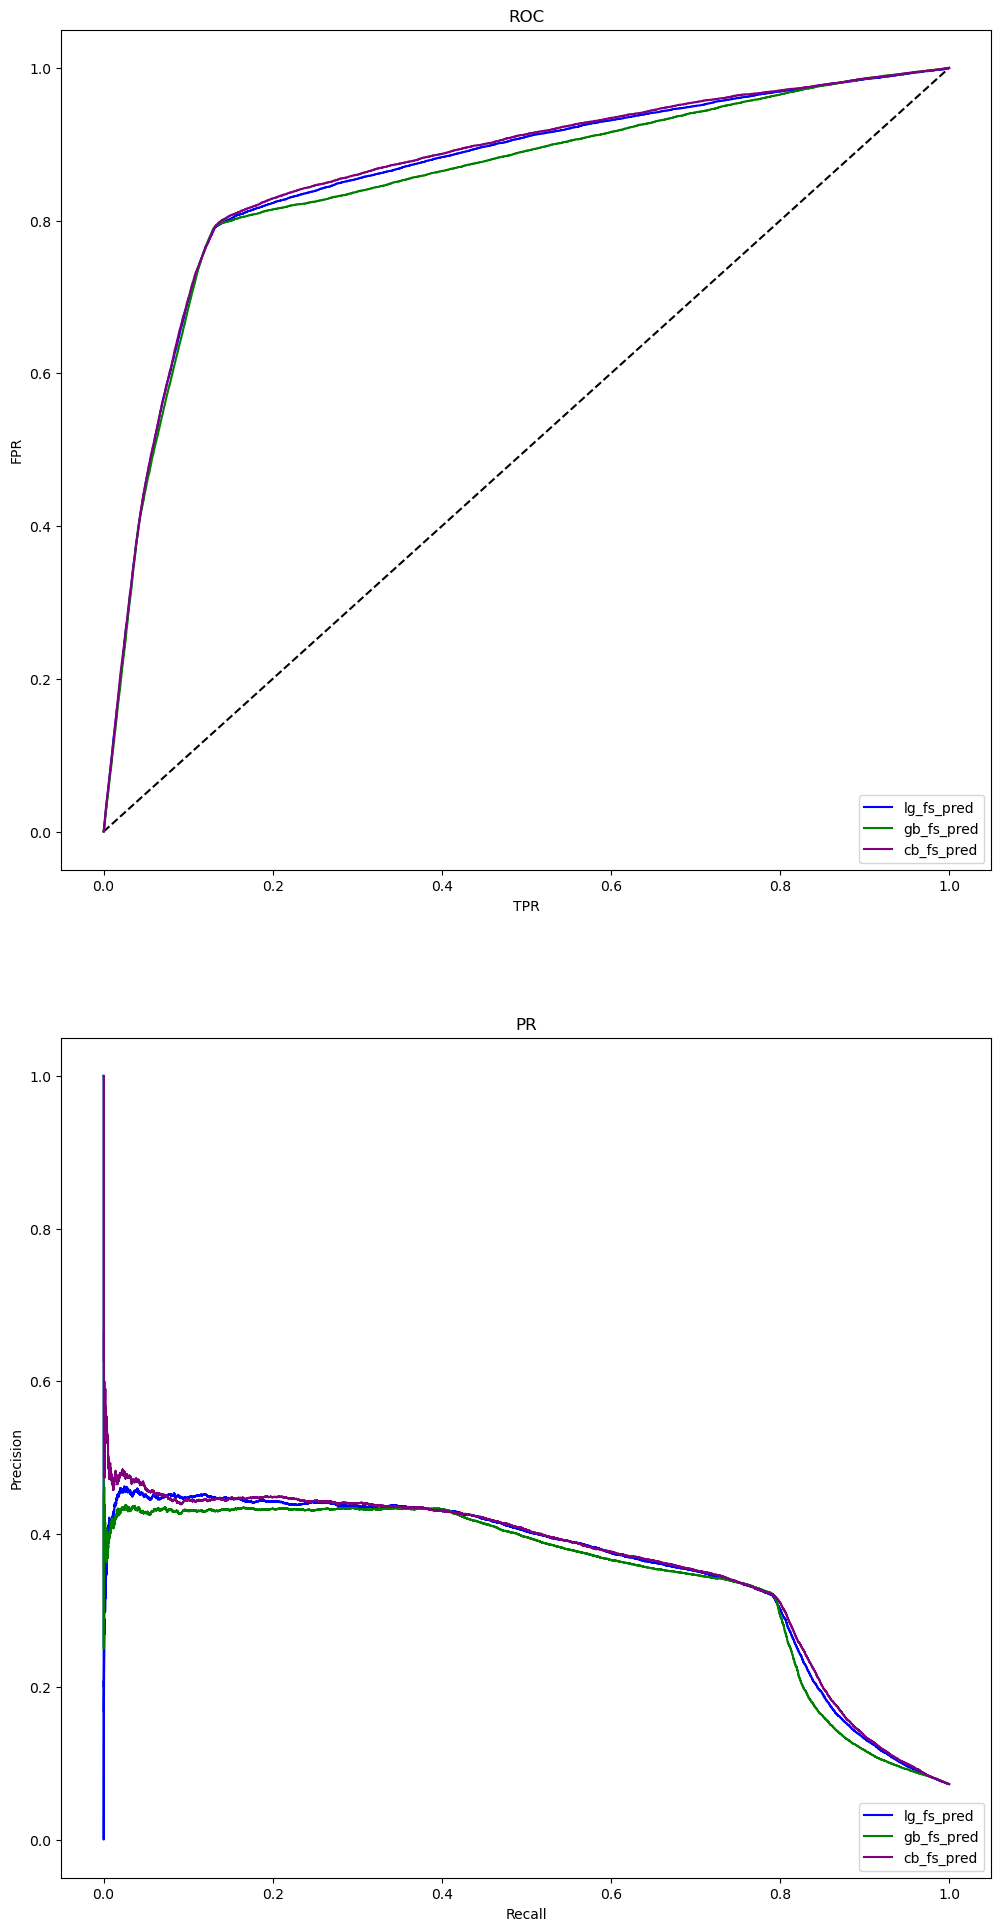

In [168]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

f.set_figheight(24)
f.set_figwidth(12)

ax1 = plt.subplot(211)
ax1.set_title('ROC')
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')

ax2 = plt.subplot(212)
ax2.set_title('PR')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

ax1.plot([0, 1], [0, 1], 'k--')

fpr, tpr, roc_thresholds = roc_curve(y_val, lg_fs_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_val, lg_fs_pred)
ax1.plot(fpr, tpr, label='lg_fs_pred', color='b')
ax2.plot(recall, precision, label='lg_fs_pred', color='b')
print('lg_fs_pred: AUC_PR = %.3f' % auc(recall, precision))
print('lg_fs_pred: AUC_ROC = %.3f' % auc(fpr, tpr))

fpr, tpr, roc_thresholds = roc_curve(y_val, rfc_fs_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_val, rfc_fs_pred)
ax1.plot(fpr, tpr, label='gb_fs_pred', color='g')
ax2.plot(recall, precision, label='gb_fs_pred', color='g')
print('rfc_fs_pred: AUC_PR = %.3f' % auc(recall, precision))
print('rfc_fs_pred: AUC_ROC = %.3f' % auc(fpr, tpr))

fpr, tpr, roc_thresholds = roc_curve(y_val, gb_fs_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_val, gb_fs_pred)
ax1.plot(fpr, tpr, label='cb_fs_pred', color='purple')
ax2.plot(recall, precision, label='cb_fs_pred', color='purple')
print('gb_fs_pred: AUC_PR = %.3f' % auc(recall, precision))
print('gb_fs_pred: AUC_ROC = %.3f' % auc(fpr, tpr))

ax1.legend(loc='lower right')
ax2.legend(loc='lower right');

исходя из значений ROC_AUC выберем модель Градиентный бустинг

In [169]:
def plot_confusion_matrix(cm, classes,
                          model_name='',
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color='white' if cm[i, j] > thresh else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[201014  30364]
 [  3778  14340]]


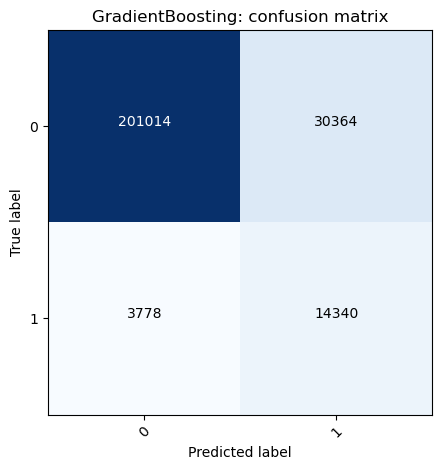

In [170]:


cm = confusion_matrix(y_val, gb_fs_pred > 0.5)
plot_confusion_matrix(cm, classes=['0', '1'], model_name='GradientBoosting');



#### Сохранине модели

In [172]:
with open('gb_classifier_model.pickle', 'wb') as f:
    pickle.dump(gb_fs_pipe_final, f, protocol=pickle.HIGHEST_PROTOCOL)